In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 设置参数
freq = 4e9  # 4 GHz载波频率
fs = 32e9   # 32 GHz采样率
symbol_duration = 2e-9  # 每个symbol 2ns
total_symbols = 8  # 总共8个symbols
total_duration = symbol_duration * total_symbols  # 总时间 16ns

# 生成时间轴
t = np.arange(0, total_duration, 1/fs)
omega = 2 * np.pi * freq

print(f"载波频率: {freq/1e9:.1f} GHz")
print(f"采样率: {fs/1e9:.1f} GHz")
print(f"Symbol持续时间: {symbol_duration*1e9:.1f} ns")
print(f"总symbols数: {total_symbols}")
print(f"总时间长度: {total_duration*1e9:.1f} ns")
print(f"每个symbol的采样点数: {int(symbol_duration * fs)}")
print(f"总采样点数: {len(t)}")


载波频率: 4.0 GHz
采样率: 32.0 GHz
Symbol持续时间: 2.0 ns
总symbols数: 8
总时间长度: 16.0 ns
每个symbol的采样点数: 64
总采样点数: 512


In [2]:
# 方法1: 分段常数相位噪声（每个symbol内相位噪声恒定）
def generate_symbol_wise_phase_noise(t, symbol_duration, phase_noise_std, seed=42):
    """
    生成symbol级别的分段常数相位噪声
    """
    np.random.seed(seed)
    samples_per_symbol = int(symbol_duration * fs)
    
    # 为每个symbol生成一个随机相位噪声值
    num_symbols = int(len(t) / samples_per_symbol)
    symbol_phase_noise = np.random.normal(0, phase_noise_std, num_symbols)
    
    # 将每个symbol的相位噪声扩展到所有采样点
    phase_noise = np.repeat(symbol_phase_noise, samples_per_symbol)
    
    # 处理剩余的采样点（如果总长度不是symbol长度的整数倍）
    remaining_samples = len(t) - len(phase_noise)
    if remaining_samples > 0:
        phase_noise = np.concatenate([phase_noise, 
                                    np.full(remaining_samples, symbol_phase_noise[-1])])
    
    return phase_noise[:len(t)]

# 生成symbol级相位噪声
phase_noise_std = 0.1  # 相位噪声标准差（弧度）
phase_noise_symbol = generate_symbol_wise_phase_noise(t, symbol_duration, phase_noise_std)

print("方法1: Symbol级分段常数相位噪声")
print(f"相位噪声标准差: {phase_noise_std:.3f} 弧度 ({phase_noise_std*180/np.pi:.1f}度)")
print(f"每个symbol内相位噪声恒定")
print(f"Symbol边界处可能有相位跳变")


方法1: Symbol级分段常数相位噪声
相位噪声标准差: 0.100 弧度 (5.7度)
每个symbol内相位噪声恒定
Symbol边界处可能有相位跳变


In [3]:
# 方法2: 低通滤波相位噪声（相位噪声变化较慢）
def generate_lowpass_phase_noise(t, cutoff_freq, phase_noise_std, seed=42):
    """
    生成低通滤波的相位噪声
    cutoff_freq: 截止频率，决定相位噪声变化的快慢
    """
    np.random.seed(seed)
    
    # 生成白噪声
    white_noise = np.random.normal(0, 1, len(t))
    
    # 设计低通滤波器
    nyquist = fs / 2
    normalized_cutoff = cutoff_freq / nyquist
    b, a = signal.butter(4, normalized_cutoff, btype='low')
    
    # 滤波得到相关的相位噪声
    filtered_noise = signal.filtfilt(b, a, white_noise)
    
    # 标准化到期望的标准差
    filtered_noise = filtered_noise / np.std(filtered_noise) * phase_noise_std
    
    return filtered_noise

# 生成低通滤波相位噪声
# 截止频率设为symbol rate的1/4，使相位噪声在symbol周期内相对稳定
symbol_rate = 1 / symbol_duration  # 500 MHz
cutoff_freq = symbol_rate / 4  # 125 MHz
phase_noise_lowpass = generate_lowpass_phase_noise(t, cutoff_freq, phase_noise_std)

print("\n方法2: 低通滤波相位噪声")
print(f"Symbol rate: {symbol_rate/1e6:.0f} MHz")
print(f"滤波器截止频率: {cutoff_freq/1e6:.0f} MHz")
print(f"相位噪声在symbol周期内变化较慢")



方法2: 低通滤波相位噪声
Symbol rate: 500 MHz
滤波器截止频率: 125 MHz
相位噪声在symbol周期内变化较慢


In [4]:
# 方法3: 相关相位噪声（一阶马尔可夫过程）
def generate_correlated_phase_noise(t, correlation_time, phase_noise_std, seed=42):
    """
    生成具有时间相关性的相位噪声
    correlation_time: 相关时间，决定相位噪声的记忆长度
    """
    np.random.seed(seed)
    
    dt = t[1] - t[0]  # 时间步长
    alpha = np.exp(-dt / correlation_time)  # 相关系数
    
    # 噪声方差，确保稳态方差为 phase_noise_std^2
    noise_var = phase_noise_std**2 * (1 - alpha**2)
    
    # 生成相关噪声序列
    phase_noise = np.zeros(len(t))
    phase_noise[0] = np.random.normal(0, phase_noise_std)
    
    for i in range(1, len(t)):
        phase_noise[i] = alpha * phase_noise[i-1] + np.random.normal(0, np.sqrt(noise_var))
    
    return phase_noise

# 生成相关相位噪声
# 相关时间设为symbol周期的2倍，使相位噪声在symbol内相对稳定
correlation_time = 2 * symbol_duration  # 4ns
phase_noise_correlated = generate_correlated_phase_noise(t, correlation_time, phase_noise_std)

print("\n方法3: 相关相位噪声（一阶马尔可夫）")
print(f"相关时间: {correlation_time*1e9:.1f} ns")
print(f"相关时间/Symbol周期比: {correlation_time/symbol_duration:.1f}")
print(f"相位噪声具有时间记忆性")



方法3: 相关相位噪声（一阶马尔可夫）
相关时间: 4.0 ns
相关时间/Symbol周期比: 2.0
相位噪声具有时间记忆性


In [5]:
# 对比方法: 逐点独立相位噪声（传统方法）
np.random.seed(42)
phase_noise_independent = np.random.normal(0, phase_noise_std, len(t))

print("\n对比方法: 逐点独立相位噪声")
print(f"每个采样点都有独立的随机相位噪声")
print(f"相位噪声变化最快")

# 生成所有信号
# 原始信号（无相位噪声）
phase_clean = omega * t
signal_clean = np.cos(phase_clean)

# 带不同类型相位噪声的信号
signal_symbol = np.cos(omega * t + phase_noise_symbol)
signal_lowpass = np.cos(omega * t + phase_noise_lowpass) 
signal_correlated = np.cos(omega * t + phase_noise_correlated)
signal_independent = np.cos(omega * t + phase_noise_independent)

print("\n=== 所有信号已生成 ===")
print(f"信号长度: {len(t)} 采样点")
print(f"时间范围: 0 到 {total_duration*1e9:.1f} ns")



对比方法: 逐点独立相位噪声
每个采样点都有独立的随机相位噪声
相位噪声变化最快

=== 所有信号已生成 ===
信号长度: 512 采样点
时间范围: 0 到 16.0 ns


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

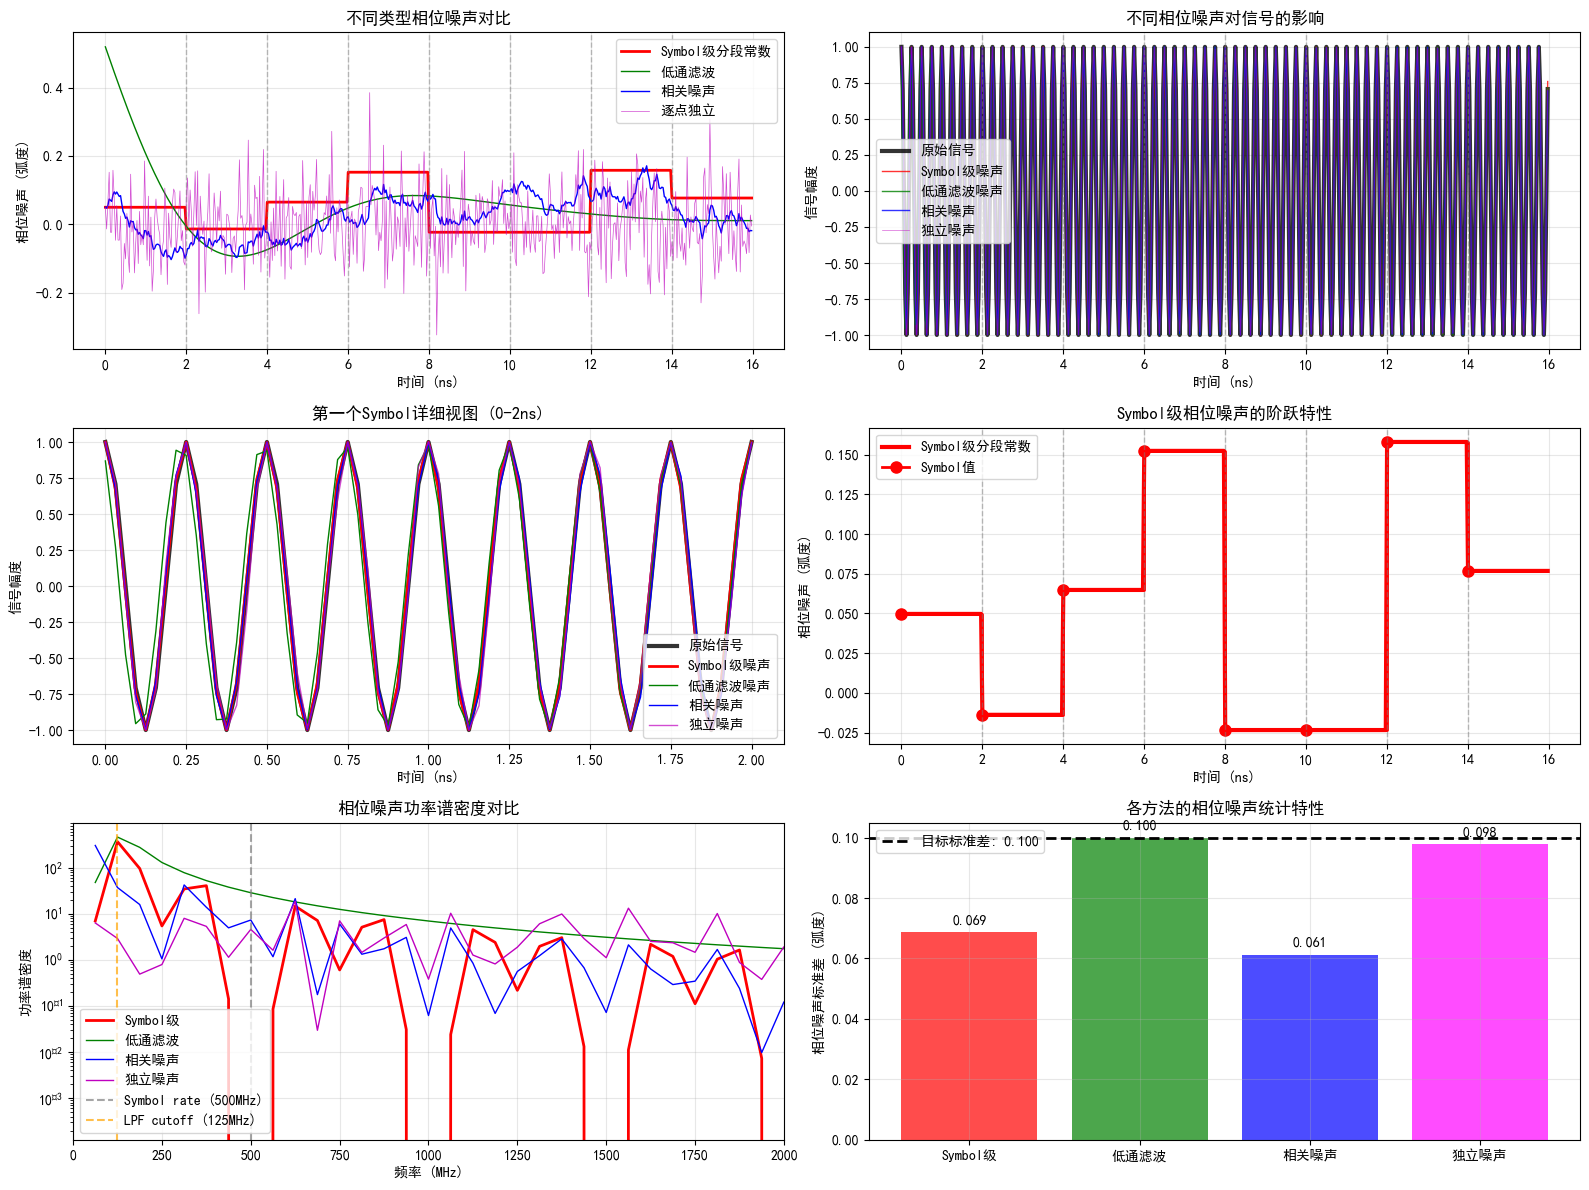

In [6]:
# 可视化对比所有方法
plt.figure(figsize=(16, 12))

# 转换时间轴到纳秒
t_ns = t * 1e9

# 添加symbol边界线的辅助函数
def add_symbol_boundaries(ax):
    for i in range(1, total_symbols):
        ax.axvline(i * symbol_duration * 1e9, color='gray', linestyle='--', alpha=0.5, linewidth=1)

# 1. 相位噪声对比
plt.subplot(3, 2, 1)
plt.plot(t_ns, phase_noise_symbol, 'r-', linewidth=2, label='Symbol级分段常数')
plt.plot(t_ns, phase_noise_lowpass, 'g-', linewidth=1, label='低通滤波')
plt.plot(t_ns, phase_noise_correlated, 'b-', linewidth=1, label='相关噪声')
plt.plot(t_ns, phase_noise_independent, 'm-', linewidth=0.5, alpha=0.7, label='逐点独立')
add_symbol_boundaries(plt.gca())
plt.xlabel('时间 (ns)')
plt.ylabel('相位噪声 (弧度)')
plt.title('不同类型相位噪声对比')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. 信号对比 - 所有信号
plt.subplot(3, 2, 2)
plt.plot(t_ns, signal_clean, 'k-', linewidth=3, alpha=0.8, label='原始信号')
plt.plot(t_ns, signal_symbol, 'r-', linewidth=1, alpha=0.8, label='Symbol级噪声')
plt.plot(t_ns, signal_lowpass, 'g-', linewidth=1, alpha=0.8, label='低通滤波噪声')
plt.plot(t_ns, signal_correlated, 'b-', linewidth=1, alpha=0.8, label='相关噪声')
plt.plot(t_ns, signal_independent, 'm-', linewidth=0.5, alpha=0.6, label='独立噪声')
add_symbol_boundaries(plt.gca())
plt.xlabel('时间 (ns)')
plt.ylabel('信号幅度')
plt.title('不同相位噪声对信号的影响')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. 局部放大：第一个symbol (0-2ns)
plt.subplot(3, 2, 3)
mask = t_ns <= 2
plt.plot(t_ns[mask], signal_clean[mask], 'k-', linewidth=3, alpha=0.8, label='原始信号')
plt.plot(t_ns[mask], signal_symbol[mask], 'r-', linewidth=2, label='Symbol级噪声')
plt.plot(t_ns[mask], signal_lowpass[mask], 'g-', linewidth=1, label='低通滤波噪声')
plt.plot(t_ns[mask], signal_correlated[mask], 'b-', linewidth=1, label='相关噪声')
plt.plot(t_ns[mask], signal_independent[mask], 'm-', linewidth=1, alpha=0.7, label='独立噪声')
plt.xlabel('时间 (ns)')
plt.ylabel('信号幅度')
plt.title('第一个Symbol详细视图 (0-2ns)')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Symbol级相位噪声的阶跃特性
plt.subplot(3, 2, 4)
plt.plot(t_ns, phase_noise_symbol, 'r-', linewidth=3, label='Symbol级分段常数')
plt.step(t_ns[::int(symbol_duration*fs)], phase_noise_symbol[::int(symbol_duration*fs)], 
         'ro-', where='post', linewidth=2, markersize=8, label='Symbol值')
add_symbol_boundaries(plt.gca())
plt.xlabel('时间 (ns)')
plt.ylabel('相位噪声 (弧度)')
plt.title('Symbol级相位噪声的阶跃特性')
plt.legend()
plt.grid(True, alpha=0.3)

# 5. 相位噪声的功率谱密度对比
plt.subplot(3, 2, 5)
freqs = np.fft.fftfreq(len(t), 1/fs)
psd_symbol = np.abs(np.fft.fft(phase_noise_symbol))**2
psd_lowpass = np.abs(np.fft.fft(phase_noise_lowpass))**2
psd_correlated = np.abs(np.fft.fft(phase_noise_correlated))**2
psd_independent = np.abs(np.fft.fft(phase_noise_independent))**2

# 只显示正频率部分
mask_freq = freqs > 0
freqs_plot = freqs[mask_freq] / 1e6  # 转换为MHz

plt.semilogy(freqs_plot, psd_symbol[mask_freq], 'r-', linewidth=2, label='Symbol级')
plt.semilogy(freqs_plot, psd_lowpass[mask_freq], 'g-', linewidth=1, label='低通滤波')
plt.semilogy(freqs_plot, psd_correlated[mask_freq], 'b-', linewidth=1, label='相关噪声')
plt.semilogy(freqs_plot, psd_independent[mask_freq], 'm-', linewidth=1, label='独立噪声')
plt.axvline(symbol_rate/1e6, color='gray', linestyle='--', alpha=0.7, label=f'Symbol rate ({symbol_rate/1e6:.0f}MHz)')
plt.axvline(cutoff_freq/1e6, color='orange', linestyle='--', alpha=0.7, label=f'LPF cutoff ({cutoff_freq/1e6:.0f}MHz)')
plt.xlabel('频率 (MHz)')
plt.ylabel('功率谱密度')
plt.title('相位噪声功率谱密度对比')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim([0, 2000])  # 限制显示到2GHz

# 6. 统计分析
plt.subplot(3, 2, 6)
methods = ['Symbol级', '低通滤波', '相关噪声', '独立噪声']
std_values = [np.std(phase_noise_symbol), np.std(phase_noise_lowpass), 
              np.std(phase_noise_correlated), np.std(phase_noise_independent)]
colors = ['red', 'green', 'blue', 'magenta']

bars = plt.bar(methods, std_values, color=colors, alpha=0.7)
plt.axhline(phase_noise_std, color='black', linestyle='--', linewidth=2, label=f'目标标准差: {phase_noise_std:.3f}')
plt.ylabel('相位噪声标准差 (弧度)')
plt.title('各方法的相位噪声统计特性')
plt.legend()
plt.grid(True, alpha=0.3)

# 在每个柱子上显示数值
for bar, value in zip(bars, std_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
             f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [7]:
# 详细分析每种方法的特性
print("=== 各种Symbol级相位噪声方法的详细分析 ===\n")

# 计算每个symbol内的相位噪声变化
samples_per_symbol = int(symbol_duration * fs)

print("1. Symbol级分段常数相位噪声:")
print("   特点: 每个symbol内相位噪声完全恒定")
print("   优点: 最符合'symbol级整体噪声'的要求")
print("   缺点: symbol边界处有突然跳变，不够真实")
print("   应用: 理想化仿真，强调symbol间的相位差异")

# 计算每个symbol内的相位噪声方差
symbol_variances = []
for i in range(total_symbols):
    start_idx = i * samples_per_symbol
    end_idx = (i + 1) * samples_per_symbol
    symbol_variance = np.var(phase_noise_symbol[start_idx:end_idx])
    symbol_variances.append(symbol_variance)

print(f"   每个symbol内方差: {np.mean(symbol_variances):.6f} (理论值应该为0)")
print()

print("2. 低通滤波相位噪声:")
print("   特点: 相位噪声连续变化，但变化较慢")
print("   优点: 更真实，无突变，可控制变化速度")
print("   缺点: symbol内仍有小幅变化")
print("   应用: 模拟实际振荡器的相位噪声特性")

# 计算symbol内的变化程度
symbol_variations = []
for i in range(total_symbols):
    start_idx = i * samples_per_symbol
    end_idx = (i + 1) * samples_per_symbol
    symbol_range = np.max(phase_noise_lowpass[start_idx:end_idx]) - np.min(phase_noise_lowpass[start_idx:end_idx])
    symbol_variations.append(symbol_range)

print(f"   平均每个symbol内变化范围: {np.mean(symbol_variations):.6f} 弧度")
print()

print("3. 相关相位噪声 (一阶马尔可夫):")
print("   特点: 具有记忆性，平滑变化")
print("   优点: 物理意义明确，可调节相关时间")
print("   缺点: 参数设计需要经验")
print("   应用: 模拟有记忆性的噪声源")

# 计算相关系数
correlation_coeff = np.corrcoef(phase_noise_correlated[:-1], phase_noise_correlated[1:])[0,1]
print(f"   相邻样点相关系数: {correlation_coeff:.6f}")
print()

print("4. 逐点独立相位噪声 (对比参考):")
print("   特点: 每个采样点独立随机")
print("   优点: 实现简单，理论分析容易")
print("   缺点: 变化太快，不符合实际物理系统")
print("   应用: 理论分析，极端噪声情况")

# 计算相邻样点的相关性
correlation_coeff_indep = np.corrcoef(phase_noise_independent[:-1], phase_noise_independent[1:])[0,1]
print(f"   相邻样点相关系数: {correlation_coeff_indep:.6f} (理论值应该接近0)")
print()


=== 各种Symbol级相位噪声方法的详细分析 ===

1. Symbol级分段常数相位噪声:
   特点: 每个symbol内相位噪声完全恒定
   优点: 最符合'symbol级整体噪声'的要求
   缺点: symbol边界处有突然跳变，不够真实
   应用: 理想化仿真，强调symbol间的相位差异
   每个symbol内方差: 0.000000 (理论值应该为0)

2. 低通滤波相位噪声:
   特点: 相位噪声连续变化，但变化较慢
   优点: 更真实，无突变，可控制变化速度
   缺点: symbol内仍有小幅变化
   应用: 模拟实际振荡器的相位噪声特性
   平均每个symbol内变化范围: 0.104601 弧度

3. 相关相位噪声 (一阶马尔可夫):
   特点: 具有记忆性，平滑变化
   优点: 物理意义明确，可调节相关时间
   缺点: 参数设计需要经验
   应用: 模拟有记忆性的噪声源
   相邻样点相关系数: 0.980088

4. 逐点独立相位噪声 (对比参考):
   特点: 每个采样点独立随机
   优点: 实现简单，理论分析容易
   缺点: 变化太快，不符合实际物理系统
   应用: 理论分析，极端噪声情况
   相邻样点相关系数: -0.009076 (理论值应该接近0)



In [8]:
# 实用建议和参数选择指导
print("=== 实用建议和参数选择 ===\n")

print("根据应用场景选择合适的方法:")
print()

print("📌 如果要求Symbol内相位噪声严格恒定:")
print("   → 选择 '分段常数' 方法")
print("   → 参数: 每个symbol一个随机值")
print("   → 适用: 理论分析、极端条件仿真")
print()

print("📌 如果要模拟实际硬件的相位噪声:")
print("   → 选择 '低通滤波' 或 '相关噪声' 方法")
print("   → 低通滤波参数建议:")
print(f"     * 截止频率 = Symbol_rate / (2~10) = {symbol_rate/1e6/2:.0f}~{symbol_rate/1e6/10:.0f} MHz")
print("   → 相关噪声参数建议:")
print(f"     * 相关时间 = (1~5) × Symbol_period = {symbol_duration*1e9:.1f}~{5*symbol_duration*1e9:.1f} ns")
print()

print("📌 如果要分析最坏情况:")
print("   → 选择 '逐点独立' 方法")
print("   → 代表最高频率的相位噪声")
print()

print("=== 参数设置建议 ===")
print(f"当前设置 (Symbol period = {symbol_duration*1e9:.1f} ns):")
print(f"• 分段常数: 每{symbol_duration*1e9:.1f}ns更新一次")
print(f"• 低通滤波: 截止频率 {cutoff_freq/1e6:.0f} MHz (Symbol rate的1/{symbol_rate/cutoff_freq:.0f})")
print(f"• 相关噪声: 相关时间 {correlation_time*1e9:.1f} ns (Symbol period的{correlation_time/symbol_duration:.1f}倍)")
print()

print("🔧 调节建议:")
print("• 增加相位噪声强度 → 增大 phase_noise_std")
print("• 使相位噪声变化更慢 → 减小 cutoff_freq 或增大 correlation_time")
print("• 使相位噪声变化更快 → 增大 cutoff_freq 或减小 correlation_time")
print()

# 展示如何修改关键参数
print("=== 代码示例：修改关键参数 ===")
print("""
# 修改相位噪声强度
phase_noise_std = 0.2  # 增大到0.2弧度 (约11.5度)

# 修改低通滤波截止频率
cutoff_freq = symbol_rate / 8  # 更慢的变化

# 修改相关时间
correlation_time = 4 * symbol_duration  # 更长的记忆

# 修改symbol周期
symbol_duration = 1e-9  # 改为1ns，对应1GHz symbol rate
""")


=== 实用建议和参数选择 ===

根据应用场景选择合适的方法:

📌 如果要求Symbol内相位噪声严格恒定:
   → 选择 '分段常数' 方法
   → 参数: 每个symbol一个随机值
   → 适用: 理论分析、极端条件仿真

📌 如果要模拟实际硬件的相位噪声:
   → 选择 '低通滤波' 或 '相关噪声' 方法
   → 低通滤波参数建议:
     * 截止频率 = Symbol_rate / (2~10) = 250~50 MHz
   → 相关噪声参数建议:
     * 相关时间 = (1~5) × Symbol_period = 2.0~10.0 ns

📌 如果要分析最坏情况:
   → 选择 '逐点独立' 方法
   → 代表最高频率的相位噪声

=== 参数设置建议 ===
当前设置 (Symbol period = 2.0 ns):
• 分段常数: 每2.0ns更新一次
• 低通滤波: 截止频率 125 MHz (Symbol rate的1/4)
• 相关噪声: 相关时间 4.0 ns (Symbol period的2.0倍)

🔧 调节建议:
• 增加相位噪声强度 → 增大 phase_noise_std
• 使相位噪声变化更慢 → 减小 cutoff_freq 或增大 correlation_time
• 使相位噪声变化更快 → 增大 cutoff_freq 或减小 correlation_time

=== 代码示例：修改关键参数 ===

# 修改相位噪声强度
phase_noise_std = 0.2  # 增大到0.2弧度 (约11.5度)

# 修改低通滤波截止频率
cutoff_freq = symbol_rate / 8  # 更慢的变化

# 修改相关时间
correlation_time = 4 * symbol_duration  # 更长的记忆

# 修改symbol周期
symbol_duration = 1e-9  # 改为1ns，对应1GHz symbol rate

